### Import Libraries

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import copy
from pyspark.ml import Pipeline
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression

### Build SparkSession
SparkSession provides a single unified entry point to all of Spark’s functionality.

In [0]:
spark = (SparkSession
    .builder
    .appName("Python Spark Classification")
    .getOrCreate())

### Load the training dataset

In [0]:
# path to data set
training_csv_file = "/FileStore/tables/Training_Data.csv"

# load the training dataset
train_df = (spark.read.format('com.databricks.spark.csv')
    .options(header='true', inferschema='true')
    .load(training_csv_file))

# convert to pandas dataframe for better display
train_df.toPandas().head()

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag
0,1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


## Data Exploration

In [0]:
# print the schema of the dataset
train_df.printSchema()

root
-- Id: integer (nullable = true)
-- income: integer (nullable = true)
-- age: integer (nullable = true)
-- experience: integer (nullable = true)
-- married: string (nullable = true)
-- house_ownership: string (nullable = true)
-- car_ownership: string (nullable = true)
-- profession: string (nullable = true)
-- city: string (nullable = true)
-- state: string (nullable = true)
-- current_job_years: integer (nullable = true)
-- current_house_years: integer (nullable = true)
-- risk_flag: integer (nullable = true)

"string" == categorical feature

"integer" == numerical feature

In [0]:
# Display shape of the dataset
print((train_df.count(), len(train_df.columns)))

(252000, 13)

In [0]:
# Separate numerical features and categorical features
num_cols = [f.name for f in train_df.schema.fields if not isinstance(f.dataType, StringType)][:-1]
cat_cols = [f.name for f in train_df.schema.fields if isinstance(f.dataType, StringType)]

In [0]:
# Display statistical summary of the numerical features
train_df.select(num_cols).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Id,252000,126000.5,72746.27825531695,1,252000
income,252000,4997116.665333333,2878311.0136018274,10310,9999938
age,252000,49.95407142857143,17.063863190284636,21,79
experience,252000,10.084436507936507,6.002589848156744,0,20
current_job_years,252000,6.333876984126984,3.6470530031609782,0,14
current_house_years,252000,11.997793650793652,1.3990369853603095,10,14


In [0]:
# Display statistical summary of the categorical features
train_df.select(cat_cols).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
married,252000,None,None,married,single
house_ownership,252000,None,None,norent_noown,rented
car_ownership,252000,None,None,no,yes
profession,252000,None,None,Air_traffic_controller,Web_designer
city,252000,None,None,Adoni,Yamunanagar
state,252000,None,None,Andhra_Pradesh,West_Bengal


In [0]:
# Check for duplicates
count_df = train_df.groupBy(train_df.columns).count().sort(col("count").desc()).toPandas()
count_df[count_df["count"] > 1]

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag,count


### Visualize the Features
We define a function called `feature_distribution` to display distribution of the features.

In [0]:
def feature_distribution(df, rotation=None, feature=None, target=None, ylabel=None, title=None, isTarget=True):
    """
    Docstring
    """
    
    plt.figure(figsize=(20,8))
    
    if isTarget:
        feature_dist = df.groupBy(feature, target).count().sort(feature).toPandas()
    
        g = sns.catplot(x=feature,
                    y="count",
                    data=feature_dist,
                    hue=target,
                    kind="bar",
                    legend_out=False)
        g.fig.set_figwidth(25)
        g.fig.set_figheight(8)
    else:
        sns.barplot(x=target, y=feature, data=df)
    
    
    plt.xticks(fontsize=20, rotation=rotation)
    plt.yticks(fontsize=20)

    plt.xlabel(None)
    plt.ylabel(ylabel, fontsize=25)
    plt.title(title, fontsize=25)

### Income Distirbution

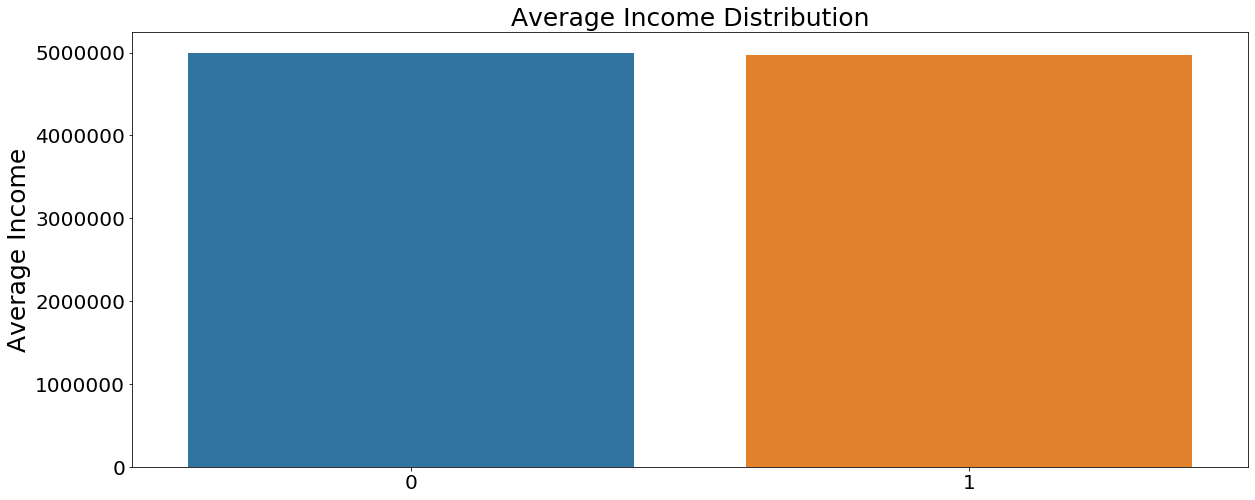

In [0]:
income_df = train_df.select("risk_flag", "income").toPandas()
income_df = income_df.groupby("risk_flag").mean().reset_index()

feature_distribution(income_df, 0, "income", "risk_flag", "Average Income", "Average Income Distribution", False)

### Age Distribution

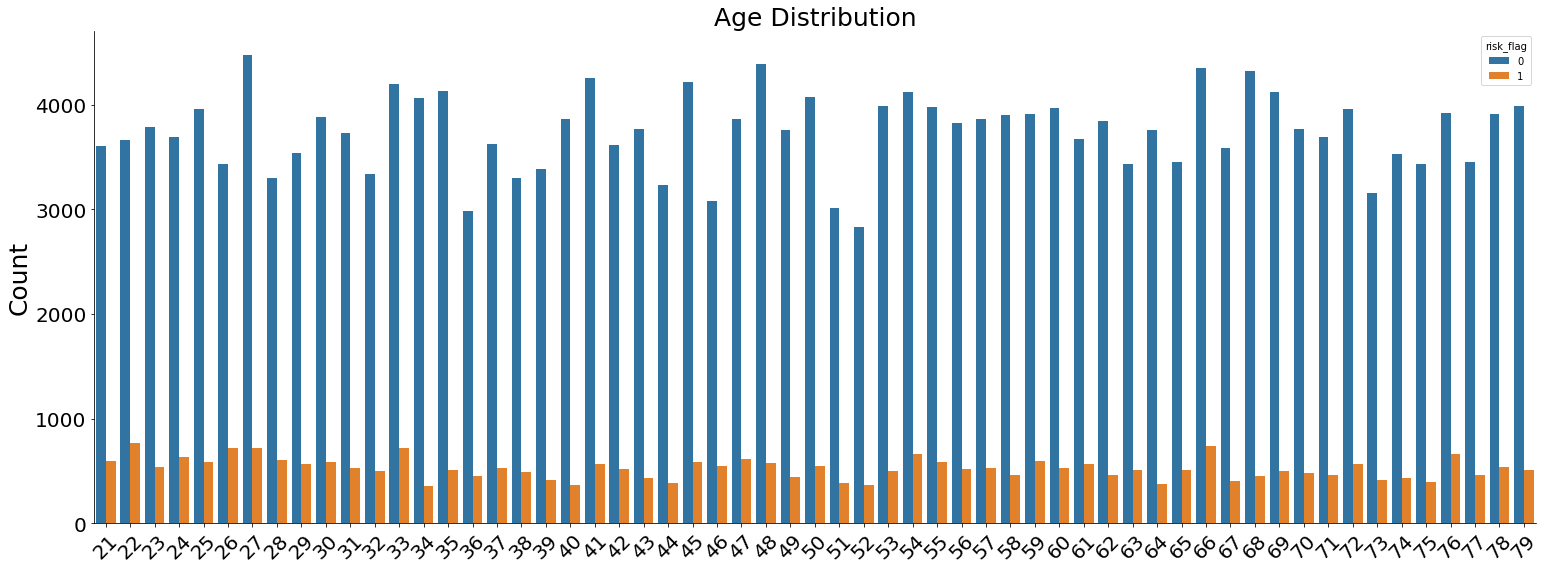

In [0]:
# Visualise the age feature distrubition
feature_distribution(train_df, 45, "age", "risk_flag", "Count", "Age Distribution")

### Experience Distribution

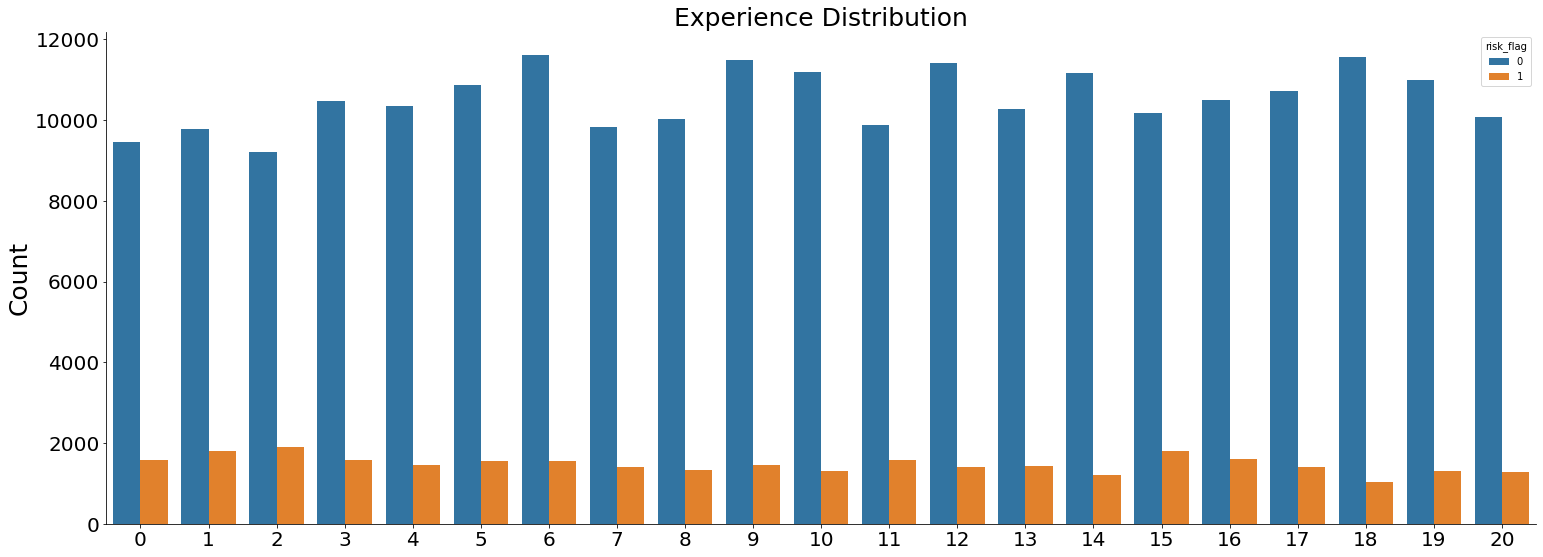

In [0]:
# Visualise the experience feature distrubition
feature_distribution(train_df, 0, "experience", "risk_flag", "Count", "Experience Distribution")

### Married Distribution

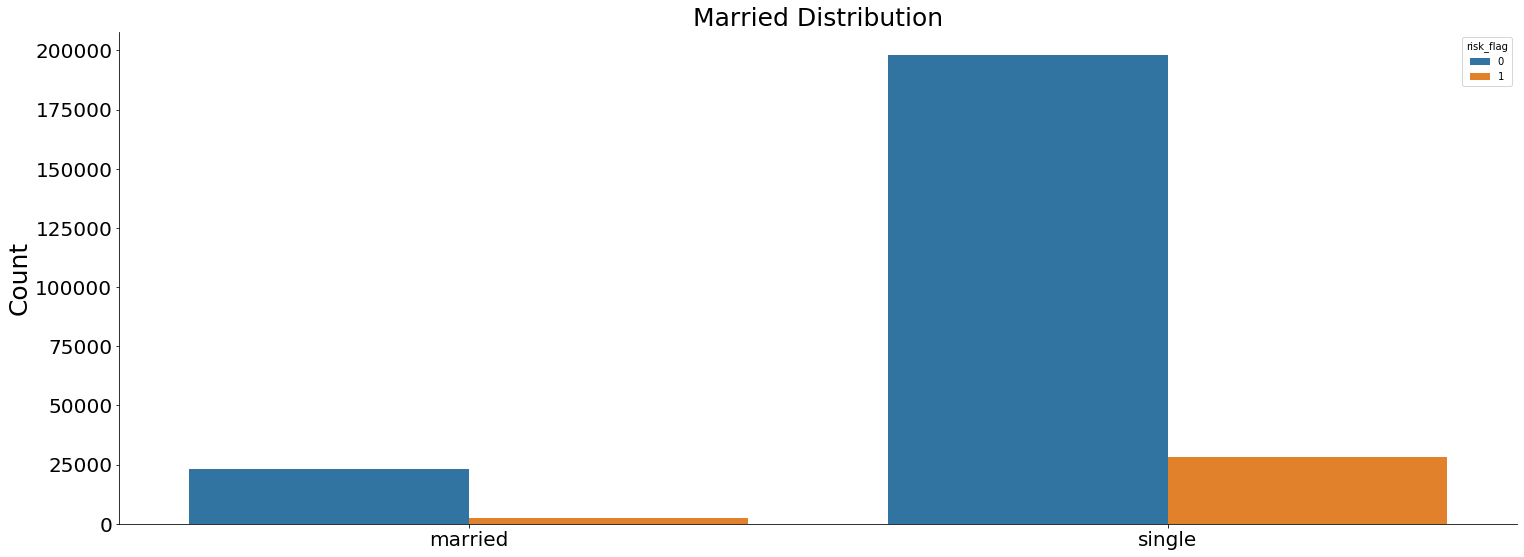

In [0]:
# Visualise the married feature distrubition
feature_distribution(train_df, 0, "married", "risk_flag", "Count", "Married Distribution")

### Housing Distribution

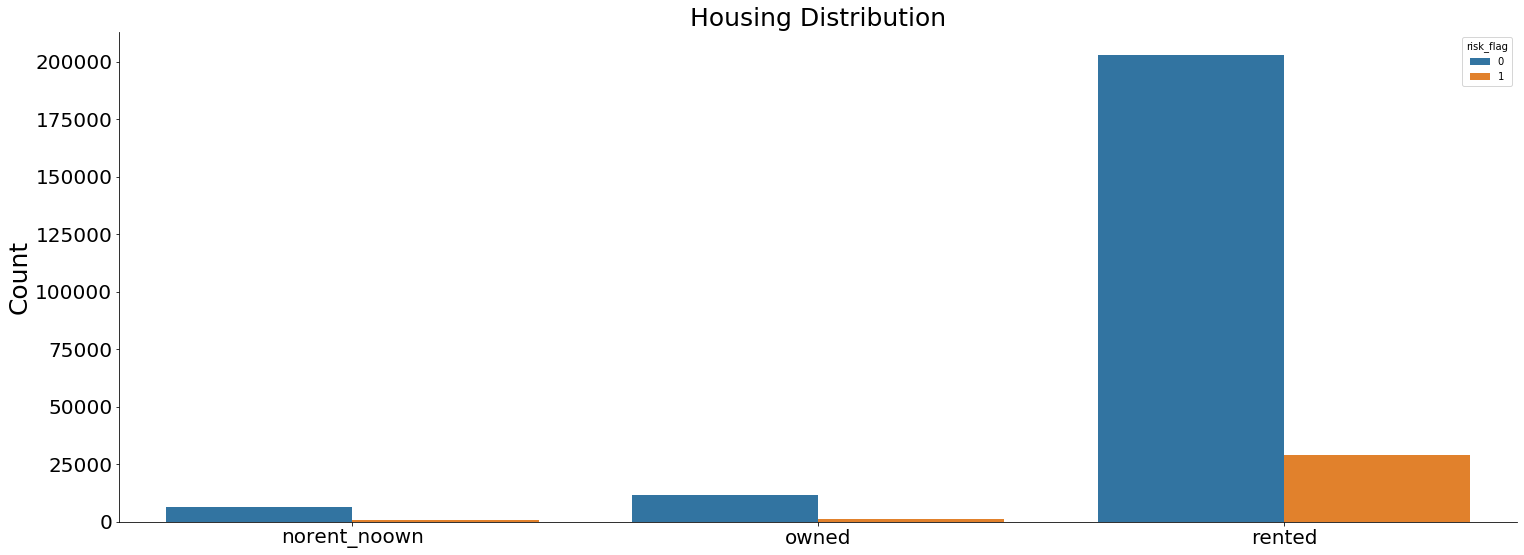

In [0]:
# Visualise the house ownership feature distrubition
feature_distribution(train_df, 0, "house_ownership", "risk_flag", "Count", "Housing Distribution")

### Car Ownership Distribution

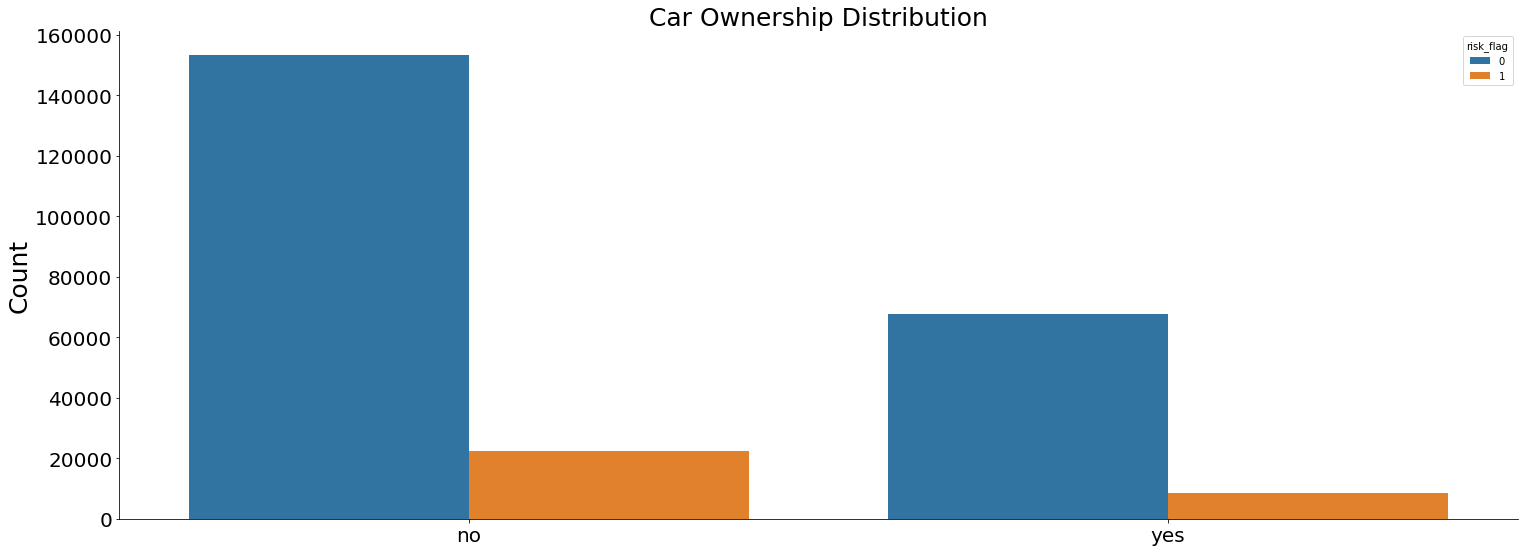

In [0]:
# Visualise the car ownership feature distrubition
feature_distribution(train_df, 0, "car_ownership", "risk_flag", "Count", "Car Ownership Distribution")

### Profession Distribution

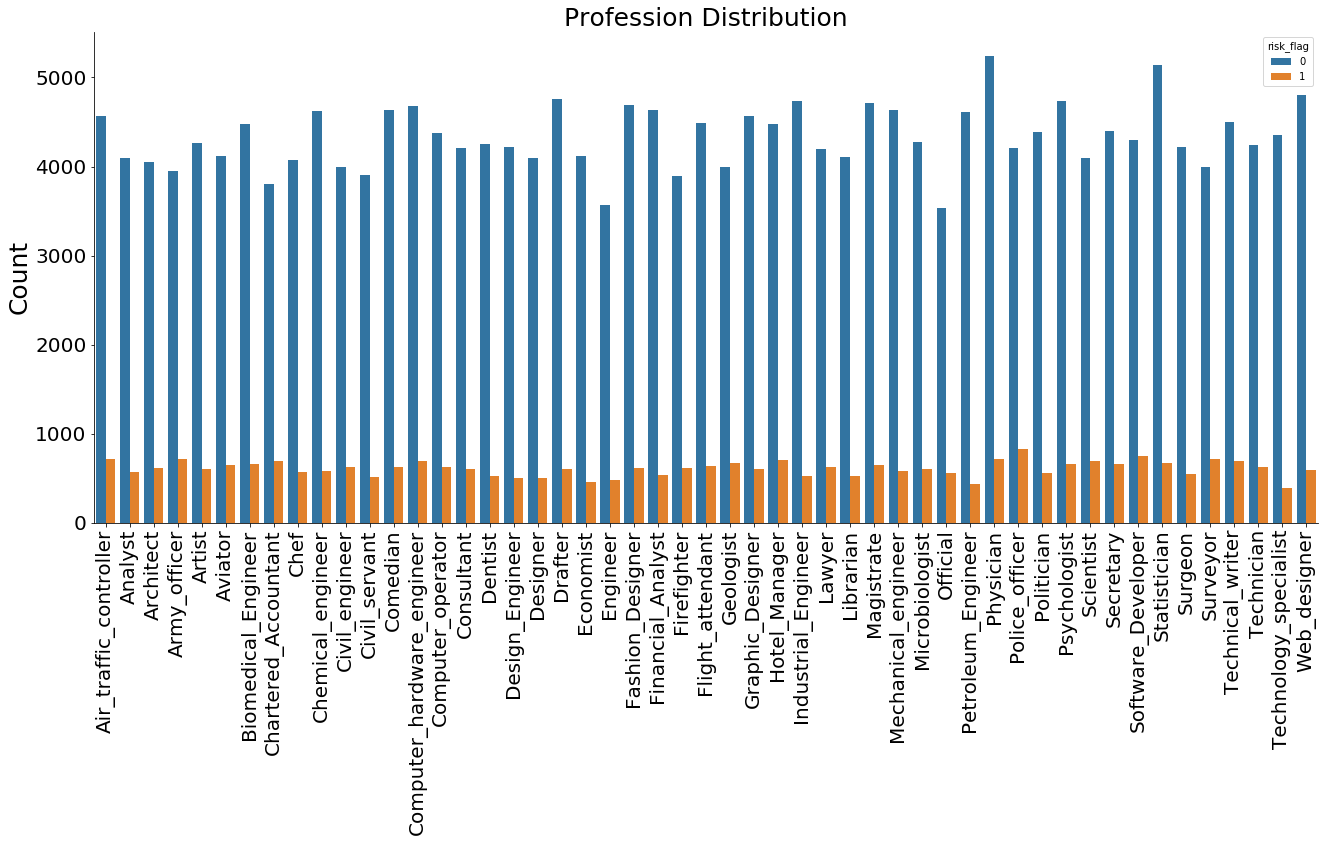

In [0]:
# Visualise the married feature distrubition
feature_distribution(train_df, 90, "profession", "risk_flag", "Count", "Profession Distribution")

### Current Job Years Distribution

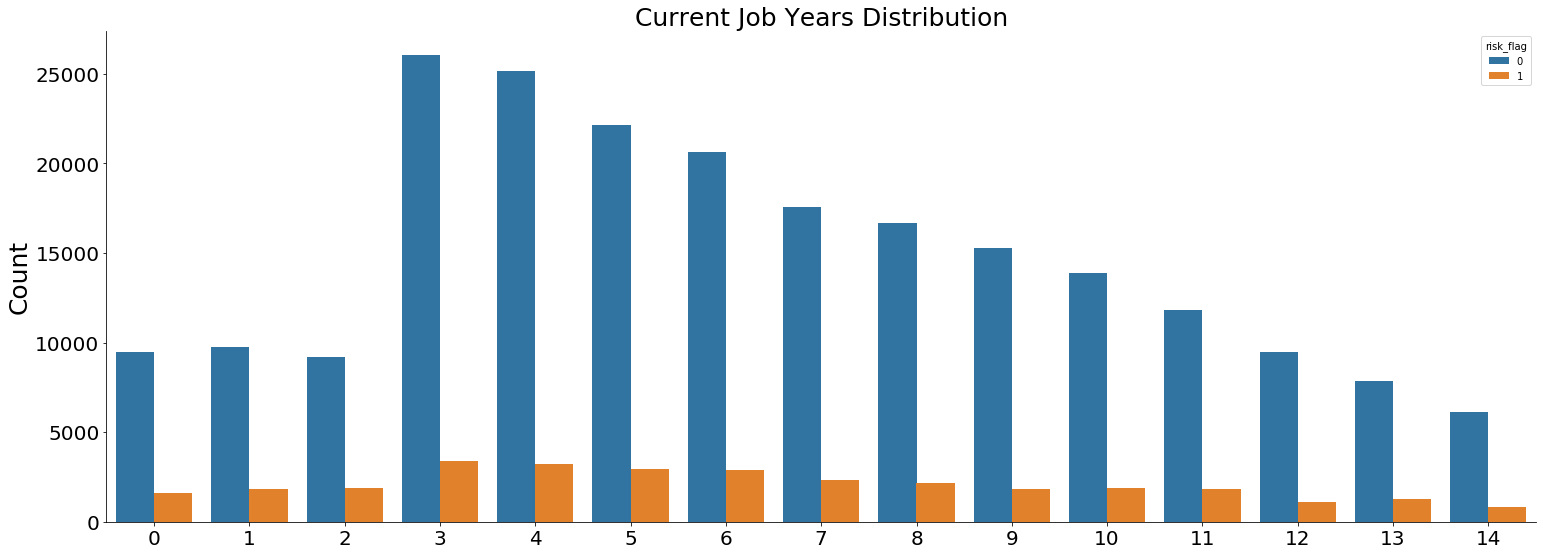

In [0]:
# Visualise the Current Job Years feature distrubition
feature_distribution(train_df, 0, "current_job_years", "risk_flag", "Count", "Current Job Years Distribution")

### Current House Years Distribution

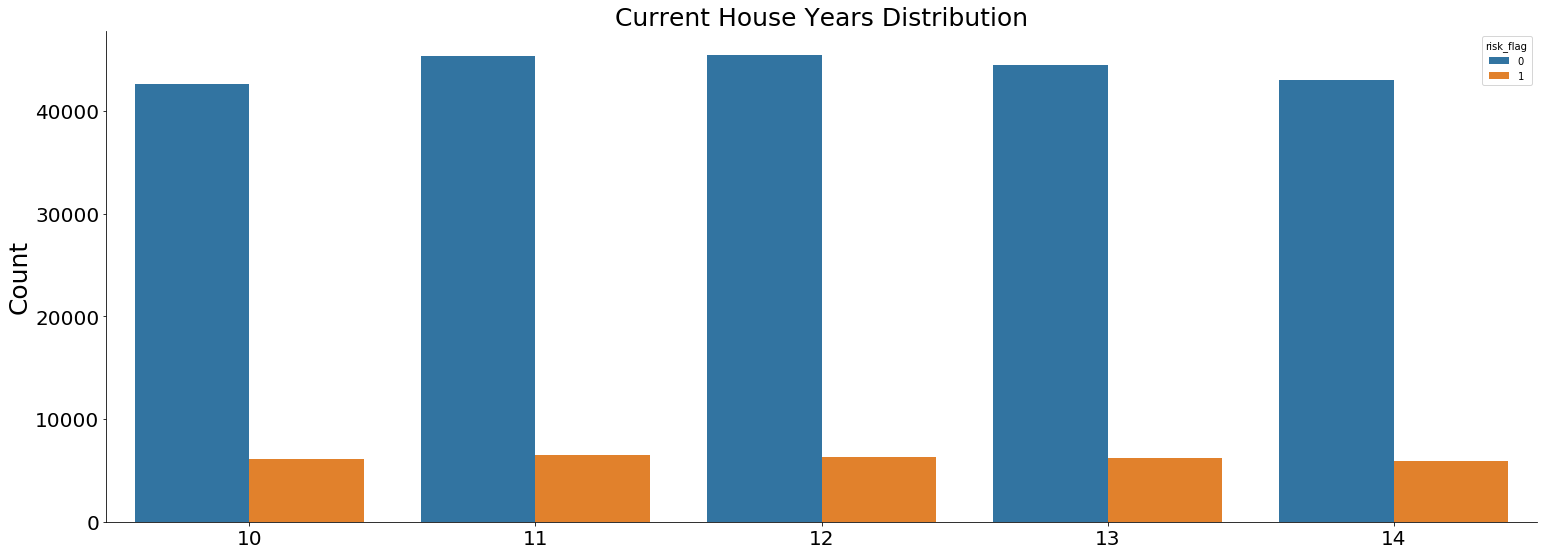

In [0]:
# Visualise the Current House Years feature distrubition
feature_distribution(train_df, 0, "current_house_years", "risk_flag", "Count", "Current House Years Distribution")

### Risk Flag Distribution

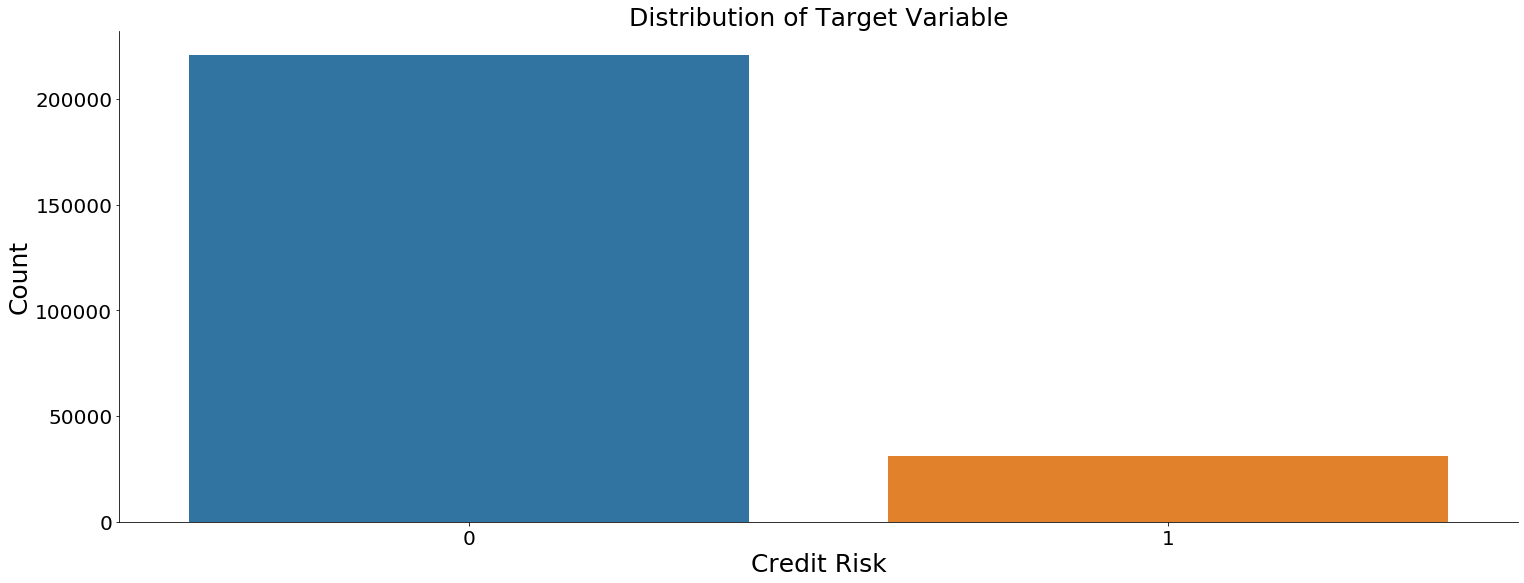

In [0]:
credit_risk = train_df.groupBy("risk_flag").count().sort("count").toPandas()

g = sns.catplot(x="risk_flag",
            y="count",
            data=credit_risk,
            kind="bar")

g.fig.set_figwidth(25)
g.fig.set_figheight(8)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel("Credit Risk", fontsize=25)
plt.ylabel("Count",fontsize=25)
plt.title("Distribution of Target Variable", fontsize=25);

In [0]:
major_train_df = train_df.filter(col("risk_flag") == 0)
minor_train_df = train_df.filter(col("risk_flag") == 1)
ratio_of_imbalance = int(major_train_df.count()/minor_train_df.count())
print("The dataset is imbalance by a factor of: {}".format(ratio_of_imbalance))

The dataset is imbalance by a factor of: 7

### Undersampling

In [0]:
# cut down the size of the majority class
undersampled_train_df = major_train_df.sample(False, 1/ratio_of_imbalance)

# combine the cut down majority rows and the minority rows
balanced_train_df = undersampled_train_df.unionAll(minor_train_df)
balanced_train_df.groupBy("risk_flag").count().toPandas()

,risk_flag,count
0,0,31748
1,1,30996


### Select attributes for modelling

In [0]:
balanced_train_df = balanced_train_df.select('income',
                                 'age',
                                 'experience',
                                 'married',
                                 'house_ownership',
                                 'car_ownership',
                                 'profession',
                                 'city',
                                 'state',
                                 'current_job_years',
                                 'current_house_years',
                                 'risk_flag')
cols = balanced_train_df.columns
balanced_train_df.printSchema()

root
-- income: integer (nullable = true)
-- age: integer (nullable = true)
-- experience: integer (nullable = true)
-- married: string (nullable = true)
-- house_ownership: string (nullable = true)
-- car_ownership: string (nullable = true)
-- profession: string (nullable = true)
-- city: string (nullable = true)
-- state: string (nullable = true)
-- current_job_years: integer (nullable = true)
-- current_house_years: integer (nullable = true)
-- risk_flag: integer (nullable = true)

### Preprocess the Dataset

In [0]:
num_cols = [f.name for f in balanced_train_df.schema.fields if not isinstance(f.dataType, StringType)][:-1]
cat_cols = [f.name for f in balanced_train_df.schema.fields if isinstance(f.dataType, StringType)]

In [0]:
num_cols

Out[25]: ['income', 'age', 'experience', 'current_job_years', 'current_house_years']

In [0]:
cat_cols

Out[26]: ['married', 'house_ownership', 'car_ownership', 'profession', 'city', 'state']

In [0]:
def preprocess_data(df, cat_cols, num_cols, isTrain=True):
    # stages in Pipeline
    stages = []
    for col in cat_cols:
        # Category Indexing with StringIndexer
        stringIndexer = StringIndexer(inputCol = col, outputCol = col + 'Index')

        # Use OneHotEncoder to convert categorical variables into binary SparseVectors
        encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + "classVec"])
        stages += [stringIndexer, encoder]
    
    if isTrain:
        # Convert label into label indices using the StringIndexer
        label_stringIdx = StringIndexer(inputCol = 'risk_flag', outputCol = 'label')
        stages += [label_stringIdx]

    # Transform all features into a vector using VectorAssembler
    assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]


    pipeline = Pipeline(stages = stages)
    pipelineModel = pipeline.fit(df)
    df= pipelineModel.transform(df)

    selectedCols = ['label', 'features'] + cols
    df = df.select(selectedCols)
    
    return df

In [0]:
processed_data = preprocess_data(balanced_train_df, cat_cols, num_cols)
processed_data.toPandas().head(2)

,label,features,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag
0,0.0,"(1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6915937,64,0,single,rented,no,Civil_servant,Jalgaon,Maharashtra,0,12,0
1,0.0,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9157379,72,13,single,rented,yes,Design_Engineer,Ajmer,Rajasthan,9,10,0


In [0]:
processed_data.printSchema()

root
-- label: double (nullable = false)
-- features: vector (nullable = true)
-- income: integer (nullable = true)
-- age: integer (nullable = true)
-- experience: integer (nullable = true)
-- married: string (nullable = true)
-- house_ownership: string (nullable = true)
-- car_ownership: string (nullable = true)
-- profession: string (nullable = true)
-- city: string (nullable = true)
-- state: string (nullable = true)
-- current_job_years: integer (nullable = true)
-- current_house_years: integer (nullable = true)
-- risk_flag: integer (nullable = true)

In [0]:
# display shape of preprocessed data
print((processed_data.count(), len(processed_data.columns)))

(62744, 14)

In [0]:
# Randomly split the dataset
train, test = processed_data.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 43967
Test Dataset Count: 18777

### Logistics Regression

In [0]:
# Instantiate and train a logistics regression model
lin_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lin_reg_Model = lin_reg.fit(train)

#### Visualise Area Under Curve (AUC) of Logistic Regression Model

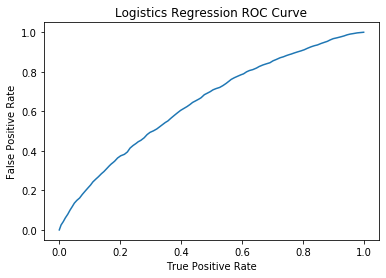

In [0]:
# Get model summary
lin_reg_Model_Summary = lin_reg_Model.summary

# Get ROC value
roc = lin_reg_Model_Summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Logistics Regression ROC Curve')
plt.show()
print('Logistics Regression AUC: ' + str(round(lin_reg_Model_Summary.areaUnderROC,2)))

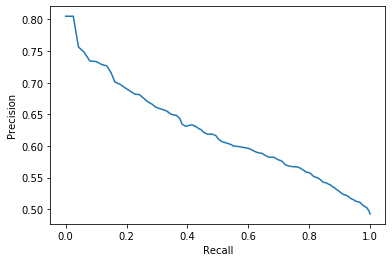

In [0]:
pr = lin_reg_Model_Summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

lr_recall = round(np.mean(pr['recall']),2)
lr_precision = round(np.mean(pr['precision']),2)
print("Logistics Regression:\n Recall - {}\n Precision - {}".format(lr_recall, lr_precision))

In [0]:
# Display predictions on test dataset
lr_predictions = lin_reg_Model.transform(test)
lr_predictions.select('label', 'prediction', 'rawPrediction', 'probability').show(10)

+-----+----------+--------------------+--------------------+
label|prediction| rawPrediction| probability|
+-----+----------+--------------------+--------------------+
 0.0| 1.0|[-0.9598681243002...|[0.27690459936466...|
 0.0| 1.0|[-0.2129188768779...|[0.44697046828588...|
 0.0| 1.0|[-0.3457064749371...|[0.41442397547444...|
 0.0| 1.0|[-0.1778960163463...|[0.45564291495372...|
 0.0| 1.0|[-0.0907612516353...|[0.47732525042336...|
 0.0| 1.0|[-0.2287795394366...|[0.44305328170893...|
 0.0| 0.0|[0.18583449326037...|[0.54632538148822...|
 0.0| 0.0|[0.37215569212049...|[0.59197976676963...|
 0.0| 0.0|[0.37215569212049...|[0.59197976676963...|
 0.0| 1.0|[-0.5306218211118...|[0.37037186981133...|
+-----+----------+--------------------+--------------------+
only showing top 10 rows

#### Evaluate the predictions of Logistics Regression

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
 
# Evaluate model
evaluator = BinaryClassificationEvaluator()
lr_test_data_AUC = evaluator.evaluate(lr_predictions)
print("Logistics Regression Test Data AUC:", str(round(lr_test_data_AUC,2)))

Logistics Regression Test Data AUC: 0.62

### Decision Tree Classifier

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier

dtree = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 5)
dtree_Model = dtree.fit(train)
dt_predictions = dtree_Model.transform(test)
dt_predictions.select('label', 'prediction', 'rawPrediction', 'probability').show(10)

+-----+----------+---------------+--------------------+
label|prediction| rawPrediction| probability|
+-----+----------+---------------+--------------------+
 0.0| 1.0|[2735.0,3401.0]|[0.44573011734028...|
 0.0| 1.0|[1772.0,2150.0]|[0.45181030086690...|
 0.0| 1.0|[2735.0,3401.0]|[0.44573011734028...|
 0.0| 0.0|[8579.0,7447.0]|[0.53531760888556...|
 0.0| 0.0|[8579.0,7447.0]|[0.53531760888556...|
 0.0| 1.0|[2735.0,3401.0]|[0.44573011734028...|
 0.0| 0.0|[8579.0,7447.0]|[0.53531760888556...|
 0.0| 0.0|[8579.0,7447.0]|[0.53531760888556...|
 0.0| 0.0|[8579.0,7447.0]|[0.53531760888556...|
 0.0| 0.0|[8579.0,7447.0]|[0.53531760888556...|
+-----+----------+---------------+--------------------+
only showing top 10 rows

#### Evaluate the predictions of Decision Tree Classifier

In [0]:
# Evaluate model
dtree_test_data_AUC = evaluator.evaluate(dt_predictions)
print("Decision Tree Test Data AUC:", str(round(dtree_test_data_AUC,2)))

Decision Tree Test Data AUC: 0.48

### Random Forest Classifier

In [0]:
from pyspark.ml.classification import RandomForestClassifier

rndForest = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rndForest_Model = rndForest.fit(train)
rndForest_predictions = rndForest_Model.transform(test)
rndForest_predictions.select('label', 'prediction', 'rawPrediction', 'probability').show(10)

+-----+----------+--------------------+--------------------+
label|prediction| rawPrediction| probability|
+-----+----------+--------------------+--------------------+
 0.0| 0.0|[10.0066675139257...|[0.50033337569628...|
 0.0| 1.0|[9.95643160793410...|[0.49782158039670...|
 0.0| 0.0|[10.0435792357726...|[0.50217896178863...|
 0.0| 0.0|[10.1197636564246...|[0.50598818282123...|
 0.0| 0.0|[10.1197636564246...|[0.50598818282123...|
 0.0| 0.0|[10.1725803772057...|[0.50862901886028...|
 0.0| 0.0|[10.1794946266601...|[0.50897473133300...|
 0.0| 0.0|[10.6070044308125...|[0.53035022154062...|
 0.0| 0.0|[10.6070044308125...|[0.53035022154062...|
 0.0| 0.0|[10.1425829048132...|[0.50712914524066...|
+-----+----------+--------------------+--------------------+
only showing top 10 rows

#### Evaluate the predictions of Random Forest Classifier

In [0]:
# Evaluate model
rndForest_test_data_AUC = evaluator.evaluate(rndForest_predictions)
print("Random Forest Test Data AUC:", str(round(rndForest_test_data_AUC,2)))

Random Forest Test Data AUC: 0.6

### Gradient-Boosted Tree Classifier

In [0]:
from pyspark.ml.classification import GBTClassifier

gboost = GBTClassifier(featuresCol = 'features', labelCol = 'label')
gboost_Model = gboost.fit(train)
gboost_predictions = gboost_Model.transform(test)
gboost_predictions.select('label', 'prediction', 'rawPrediction', 'probability').show(10)

+-----+----------+--------------------+--------------------+
label|prediction| rawPrediction| probability|
+-----+----------+--------------------+--------------------+
 0.0| 0.0|[0.00475908442024...|[0.50237952424562...|
 0.0| 1.0|[-0.1234628947058...|[0.43858031118126...|
 0.0| 1.0|[-0.0947828694027...|[0.45274997542990...|
 0.0| 0.0|[0.03589294762410...|[0.51793877094534...|
 0.0| 0.0|[0.03589294762410...|[0.51793877094534...|
 0.0| 1.0|[-0.0808495911216...|[0.45966305574415...|
 0.0| 0.0|[0.20859546393827...|[0.60281086856400...|
 0.0| 0.0|[0.03589294762410...|[0.51793877094534...|
 0.0| 0.0|[0.03589294762410...|[0.51793877094534...|
 0.0| 0.0|[0.17213397899723...|[0.58522688699815...|
+-----+----------+--------------------+--------------------+
only showing top 10 rows

#### Evaluate the predictions of Gradient -Boosted Classifier

In [0]:
# Evaluate model
gboost_test_data_AUC = evaluator.evaluate(gboost_predictions)
print("Gradient-Boosted Test Data AUC:", str(round(gboost_test_data_AUC,2)))

Gradient-Boosted Test Data AUC: 0.65